# 이미지 특징 추출

### 이미지 미분
가로/세로 위치 변화에 따른 픽셀 값의 변화율을 이미지의 도함수(Image derivatives) 라고 한다. 다음 식에서 𝑓(𝑥)는 𝑥위치의 픽셀 명도이다.

$ g_{x} = \frac{∂𝑓}{∂𝑥}, g_{y} = \frac{∂𝑓}{∂𝑦} $  

x, y 방향의 도함수의 크기를 구하는 것이 라플라스 연산이다.  

$ g = \sqrt{{g_{x}}^{2} + {g_{y}}^{2}} $  

실제 이미지 프로세싱에서는 다음과 같은 중앙차분법(central difference)을 사용한다.  

$ G(x) = f(x+1) - f(x-1) \approx \begin{bmatrix} -1 & 0 & 1 \end{bmatrix} $  

이 연산은 다음 이미지 커널을 사용하여 필터링한 것과 같다.  
$ k = [1, 0, -1] $

### 엣지 추출
경계선을 인지하는 것을 엣지 추출(egde detection)이라고 한다. 엣지(경계선)는 이미지 안에서 픽셀의 값이 값자기 변하는 곳이다. 따라서 엣지 추출을 하는 알고리즘은 이미지를 미분한 그레디언트(gradient) 벡터의 크기로 판단한다. 대표적인 엣지 추출 알고리즘으로 Sobel edge Detection과 Canny edge Dectenction이 있다.  

OpenCV 에서 Sobel edge Detection은 Sobel, Laplacian 명령으로 구현한다.

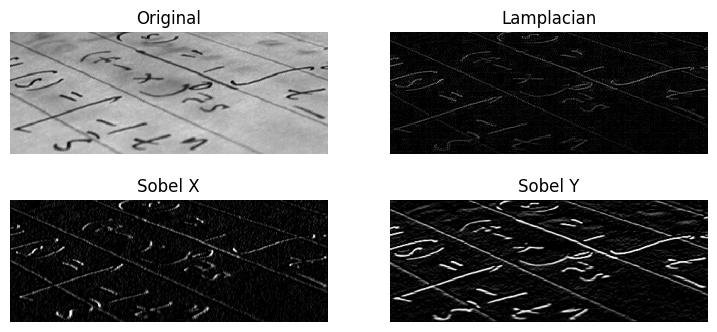

In [1]:
from skimage.data import text
import cv2
import matplotlib.pyplot as plt

img = text()

sobelx = cv2.Sobel(img, cv2.CV_8U, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_8U, 0, 1, ksize=3)
laplacian = cv2.Laplacian(img, cv2.CV_8U)

plt.figure(figsize=(9, 4))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(laplacian, cmap="gray")
plt.title("Lamplacian")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(sobelx, cmap="gray")
plt.title("Sobel X")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(sobely, cmap="gray")
plt.title("Sobel Y")
plt.axis("off")

plt.show()

### 캐니 엣지 추출
캐니 엣지 추출법은 그레디언트의 크기 뿐 아니라 방향도 사용한다. 또한 국부 최대 값 근처의 그레디언트값을 제거하는 Nonmaximal suppressioin을 이용하여 가짜 엣지를 제거한다. 마지막으로 두 개의 기준값(threshold)을 사용해서 엣지를 구분한다.  

아래 코드는 canny 함수를 사용하여 이미지의 엣지를 추출한다. 기준값으로는 50과 100을 사용하였다.

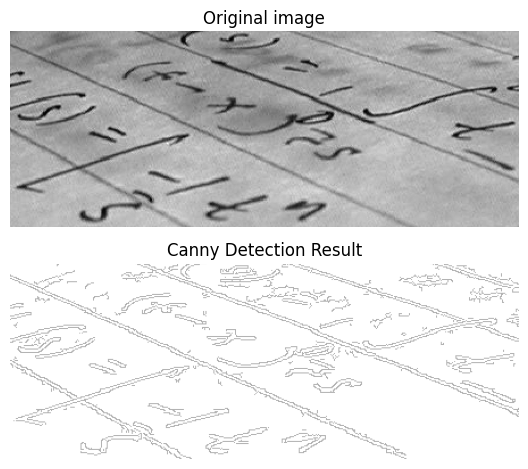

In [2]:
img = text()
edges = cv2.Canny(img, 50, 100)

plt.subplot(2, 1, 1)
plt.imshow(img, cmap="gray")
plt.title("Original image")
plt.axis("off")

plt.subplot(2, 1, 2)
plt.imshow(edges, cmap="Greys", alpha=0.3)
plt.axis("off")
plt.title("Canny Detection Result")

plt.tight_layout()
plt.show()


### 코너 추출
코너(Corner)는 엣지가 교차되는 점이다.

### 해리스 코너 추출
해리스 코너 추출 함수 cornerHarris는 이미지 위에 커널을 이동시키면서 그레디언트의 변화량을 구하고 이 값을 적절한 기준값으로 구별하여 코너점을 찾는다.

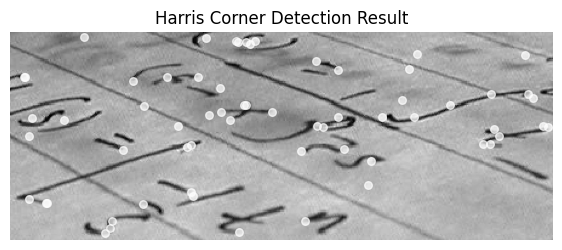

In [3]:
import numpy as np

dst = cv2.cornerHarris(img, 2, 3, 0.24)

# thresholding
ret, dst = cv2.threshold(dst, 0.001 * dst.max(), 1, 0)

x, y = np.nonzero(dst)

plt.figure(figsize=(7, 7))
plt.title("Harris Corner Detection Result")
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.scatter(y, x, s=30, c="w", alpha=0.7)
plt.show()

### Shi & Tomasi 코너 추출
Harris 코너 추출법은 모든 방향으로 그레디언트의 변화량이 큰 지점을 코너라고 판단하지만 Shi & Tomasi 코너 추출법은 더 작은 변화를 보이는 방향의 변화량이 설정한 기준값보다 크면 코너라고 판단한다. OpenCV에서 `goodFeaturesToTrack`이라는 메서드로 구현되어있다.  

`goodFeaturesTotrack(image, maxCorners, qualityLevel, minDistance)`

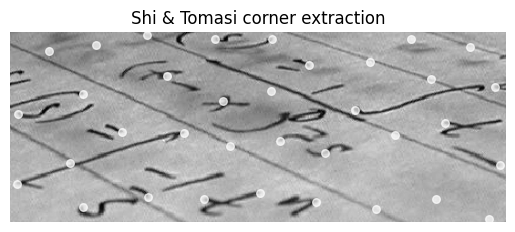

In [8]:
corners = cv2.goodFeaturesToTrack(img, 100, 0.001, 40)
corners = np.intp(corners)

plt.title("Shi & Tomasi corner extraction")
plt.imshow(img, cmap="gray")
plt.scatter(corners[:, 0, 0], corners[:, 0, 1], s=30, c="w", alpha=0.7)
plt.axis("off")
plt.show()

### 허프 라인 변환
허프 라인 변환(Hough line transformation)을 사용하면, 검출된 엣지로부터 직선을 이루는 부분을 찾아낼 수 있다.  

이미지에서 한 좌표(x1, y1)가 주어졌을 때, 그 좌표를 지나는 기울기 m과, y절편 c를 가지는 직선의 방정식
$ y_{1} = mx_{1} + c $를 정의할 수 있다. 이 때, 이 직선이 많은 엣지 좌표들을 지난다면, 그것이 이미지에 있는 직선일 확률이 높다. 한 좌표를 지나는 직선은 무한히 정의할 수 있다. Hough Line 변환에서는 주어진 좌표를 지나는 직선을 1도 단위로 180도 까지 회전시켜 180개의 2차원 배열을 만든다. 그리고 모든 점에 대해 이 연산을 수행해, 기준 값 이상의 점들을 지나는 직선의 방정식을 구한다. 이 연산을 위해, 위 직선의 방정식을 다음과 같은 극 좌표계에 나타낸다.  

$ y = \left( -\frac{cos\theta}{sin\theta} \right)x + \left( \frac{r}{sin\theta} \right) $  

이렇게 표현하면, 원점과 직선사이의 거리인 r을 다음 식 처럼 나타낼 수 있다.  

$ r = cos\theta x + sin\theta y$  

x와 y는 고정되어있고, 𝜃값을 변화 시켜, (r, 𝜃) 쌍을 만들면, 결과로 2차원 배열을 얻을 수 있다.  

이제 모든 점에 대해 이 연산을 수행하고, 기준값 보다 많은 점에서 교차되는 지점의 (r, 𝜃)값이 직선이 될 확률이 높은 지점이다. 같은 각도에서 원점에서의 거리가 같다는 것은 그 점들이 그 직선의 방정식 위에 존재한다는 의미이다. (r, 𝜃)값을 알고 있으니, 위의 극좌표계에서의 직선의 방정식에 대입하면, 이미지에서의 직선일 확률이 높은 직선의 방정식을 찾을 수 있다.  

이 방법론은 타원, 사각형, 원을 추출할 때도 사용될 수 있다.  

OpenCV에서는 이 알고리즘을 HoughLine 이라는 함수로 구현해 놓았다.  

- parameter
  - 검출한 엣지
  - r값을 정의하는 픽셀 수, 보통 1픽셀을 사용한다.
  - 𝜃값을 정의하는 단위, 보통 1도를 사용한다. r을 1로 설정하면 해당 파라미터는 𝜋/180 으로 설정한다.
  - 기준값(threshold), 직선이 교차하는 점의 최소 갯수를 의미한다.  

입력하면 엣지로부터 직선을 추출한다.  

HoughLine 방법은 연산량이 너무 많기 때문에 보통은 확률적 Hough Transformation 방법을 사용한다. 확률적 Hough Transformaion 방법은 모든 점이 아닌 임의의 점에 대해 (r, 𝜃)를 계산하는 것이다. HoughLineP라는 이름으로 구현되어 있다. 이때는 파라미터로 minLineLenght(직선의 최소 길이), maxLineGap(같은 선 내에 있는 점들의 최소 간격)이 추가된다.  

다음 코드는 Canny Detection 방법으로 엣지를 추출하고, 추출한 엣지로부터 HoughLineP 함수를 사용해 직선을 추출한다.

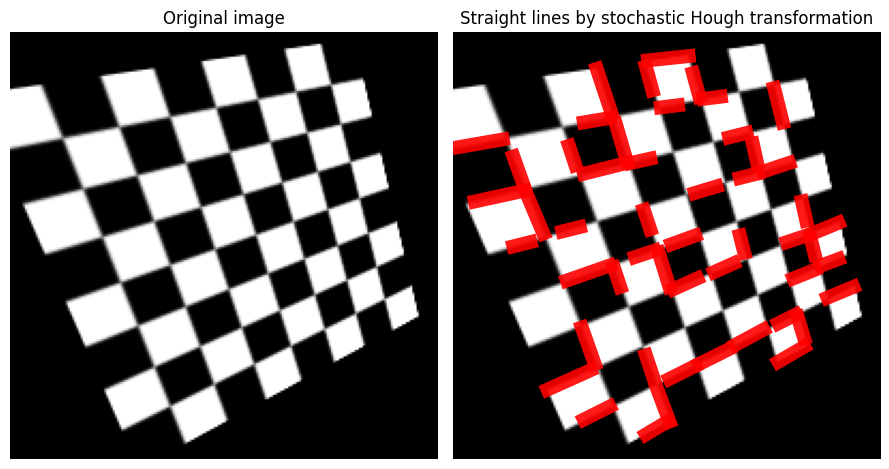

In [13]:
from skimage.data import checkerboard

img = checkerboard()
rows, cols = img.shape

pts1 = np.float32([[25, 25], [175, 25], [25, 175], [175, 175]])
pts2 = np.float32([[25, 50], [150, 25], [75, 175], [175, 125]])

H = cv2.getPerspectiveTransform(pts1, pts2)
img = cv2.warpPerspective(img, H, (cols, rows))

edges = cv2.Canny(img, 100, 150, apertureSize=3)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, 50, 8)

plt.figure(figsize=(9, 7))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")
plt.axis("off")

for i in range(len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        plt.plot([x1, x2], [y1, y2], c="r", lw=10, alpha=0.9)
plt.title("Straight lines by stochastic Hough transformation")

plt.tight_layout()
plt.show()